**Remember `shift + enter` to run a cell**

### Ion Trajectory Simulations in Quadrupole Mass Filter

#### Mass filters serve as indispensible analytical tools that stretch across disciplines
* Residual Gas Analyzers (RGAs)
* Underlying technology supporting triple quadrupole systems
  * Most sensitive mass spectrometers
* Front end separations and filters for additional high resolution systems

### But how do they work?
#### Fundamentally, they work by exploiting the stability of ions in an *oscillating* electric field
#### Conceptually the interaction of ions between RF and DC voltages establish *m/z*-based high and low pass filters that when combined can focus on a *narrow* region of *m/z* values.

<p align="center">
  <img src="http://people.whitman.edu/~dunnivfm/C_MS_Ebook/CH5/Figures/Fig_5_11_Quad2.gif" width="350px"/></p>

<p align="center">
  <img src="https://cdn.comsol.com/wordpress/2016/07/particle-trajectories-in-a-quadrupole-mass-filter.png" width="450px"/></p>

<p align="center"><font size="6">
$\frac{d^2u}{d\xi^2}+[a_u-2q_u\cos (2\xi) ]u=0 $ 

</font></p>

<p align="center"><font size="6">
$ a_u = \frac{8eU}{mr_0^2\Omega^2}$  $q_u= \frac{4eV}{mr_0^2\Omega^2} $
</font></p>

### Unless you use them routinely, your DiffEq skills are, *most likely*, a bit rusty...
* Mine are...
#### The solutions to these quations for *a* and *q* resemeble the following:

<p align="center">
  <img src="https://i.stack.imgur.com/5o4Bu.png" width="350px"/></p>

#### So how are they solved using python?

##### Leverages the ODE solver from `scipy`

Standard python imports

In [1]:
import scipy.special as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate

##### Table 1. Standard parameters for simulation

### Ideal Parameters for *a* and *q* at the Apex
|           |             |           | 
|-----------|-------------|-----------| 
| a         | 0.236985    |           | 
| q         | 0.706044    |           | 
| a/q       | 0.3356518857|           |
| $RF_{p-p}$/DC | 1/11.91645             |           | 
| r         | 0.0045      | 9 mm Diam | 
| Omega     | 1,200,000   | Hz        | 
| Omega Rho | 7539822.369 |           | 
| e         | 1.60E-19    |           | 
| m_amu     | 600         |           | 
| m_kg_calc | 9.96E-25    |  kg       | 
|           |             |           | 
| Umax      | 212.32      | V         | 
| Vmax      | 1,265.13    | V         | 


The solutions for a and q regions of stability are taken from Baluya et al. [(Ardara Technical Note TN_3008A)](https://www.ardaratech.com/downloads/technical-notes/11-tn-3008-practical-quadrupole-theory-rf-frequency/file)

##### Approximate Solution for the Mathieu Equation for the left side boundary:
*valid for the range of q = 0 to q = 0.706004*

$ a = 0.5016787{\cdot}q^2 - 0.01018488{\cdot}q^3 - 0.03838793{\cdot}q^4 $

##### Approximate Solution for the Mathieu Equation for the right side boundary:
*valid for the range of q = 0.706004 to q = 0.90803*

$ a= 1.006067 - 1.02426{\cdot}q – 0.09219{\cdot}q^2 $

In [2]:
maxq = 0.90803
numPnts = 100
deltaq = maxq/numPnts
#approx solutions
c1 = 0.5016787 #q2
c2 = -0.01018488 #q3
c3 = -0.03838793 #q4
c4 = 1.006067
c5 = -1.02426 #q
c6 = -0.09219 #q2

In [3]:
q = np.zeros(numPnts)
for i,j in enumerate(q):
    q[i] = deltaq*i

In [4]:
def a1_approx(q):
    '''
    Solution for the left side boundary
    '''
    return c1*q**2+c2*q**3+c3*q**4

In [5]:
def a2_approx(q):
    '''
    Solution for the right side boundary
    '''
    return c4+c5*q+c6*q**2

In [6]:
a1 = a1_approx(q)
a2 = a2_approx(q)

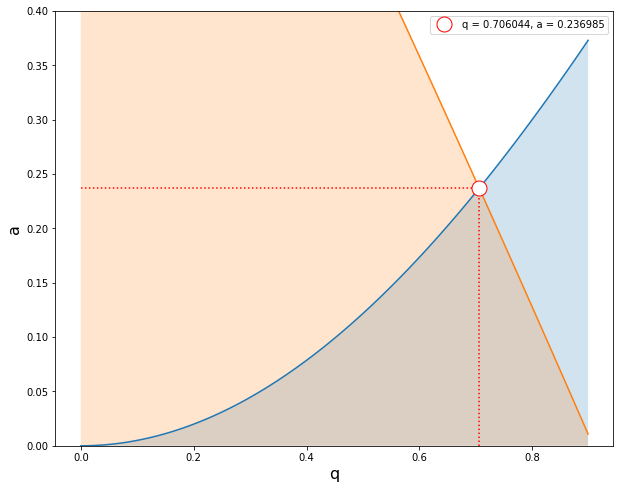

In [7]:
plt.subplots(figsize = (10,8))
plt.fill_between(q, 0, a1, alpha = 0.2)#Not quite working correctly at this stage
plt.fill_between(q, 0, a2, alpha = 0.2)#Not quite working correctly at this stage
plt.plot(q, a1)
plt.plot(q, a2)
plt.plot(0.706044, 0.236985, 'ro', ms = 15, mfc = 'white', label = 'q = 0.706044, a = 0.236985')
plt.vlines(0.706044, 0, 0.236985, 'r', linestyle = ':')
plt.hlines(0.236985, 0, 0.706044, 'r', linestyle = ':')
plt.xlabel('q', fontsize = 16)
plt.ylabel('a', fontsize = 16)
plt.ylim(0,0.4)
plt.legend()

#### Table 2. Params for stability diagram simulation
* Same caveats exists for Table 1.

|           |             |           | 
|-----------|-------------|-----------| 
| VRF Max   | 2000        |           | 
| q         | 0.706044    |           | 
|           |             |           | 
| r         | 0.0045      | 9 mm Diam | 
| Omega     | 500,000     | Hz        | 
| Omega Rho | 3141592.654 |           | 
| e         | 1.60E-19    |           | 
|           |             |           | 
| M/Z MAX   | 5,463.45    |           | 


_______

#### Adapted from Matlab/Octave to Python
* http://diy-ms.blogspot.com/
* http://fastlabtutorials.blogspot.com/2016a/09/transfer-function-toolbox-problems.html
* https://pdfs.semanticscholar.org/8d7e/bfdb4163a995ba36b7a9ac3b44410f826ade.pdf

In [8]:
def pendy(x, t, paramList):#Function describing movement in x
    '''
    Argument passing for ODEs is a little od.
    In this case the y_offset is the coordinate offset of the ion entering the quad
    vy0 -- is the original velocity of the ion in the y-direction
    ax is the value of a
    qx is the value of q in the stability diagram
    phasepi is the entrance state of the ion from a phase perspective
    '''
    y_offset = x[0]
    vy0 = x[1]
    ax = paramList[0]
    qx = paramList[1]
    phasepi = paramList[2]
    xdot = []
    xdot.append(vy0)
    xdot.append(-(-ax-2*qx*np.cos(2*t+phasepi))*y_offset)
    return xdot

In [9]:
def pendx(x, t, paramList):#Function describing movement in x
    '''
    Argument passing for ODEs is a little od.
    In this case the x_offset is the coordinate offset of the ion entering the quad
    vx0 -- is the original velocity of the ion in the x-direction
    ax is the value of a
    qx is the value of q in the stability diagram
    phasepi is the entrance state of the ion from a phase perspective
    '''
    x_offset = x[0]
    vx0 = x[1]
    ax = paramList[0]
    qx = paramList[1]
    phasepi = paramList[2]
    xdot = []
    xdot.append(vx0)
    xdot.append(-(ax+2*qx*np.cos(2*t+phasepi))*x_offset)
    return xdot

In [10]:
#### Adapted script from GNU Octave that simulates ion trajectorys through ideal electric quadrupoles
# using an numeric approach to Mathieus ODE. All calculations are performed using SI-units.
# The quadrupole and initial values can be set up through the val-variable. 
# The script is an early proof-of-concept and may contain errors. 
# Initial values are taken from S. Taylor "Simulation of ion trajectories through the mass filter
# of a quadrupole mass spectrometer"
ion_mz = 219.0#28.0    # 0 m/z  Ion-specific m/z
dc_offset = 115.0    # U  Offset voltage
rf_voltage = 800    # V  RF voltage (peak to peak)
fq = 1.2E6
rf_freq = 2*np.pi*fq       # 3 omega RF frequenzy f ... omega=2*pi*f (IS IT 3 or 2 PI)
radius = 0.0045   # 4 r0  Quad formfactor: inner radius
acc_volts = 2.0   # 5 U beschl. Acceleration voltage for the ion
delta_t = 10e-9   # 6 dt  Timeinterval for simulation
z_length = 0.15   # 7 zmax Quad formfactor: length in z
x_offset = 0.0003   # 8 x0   Entry offset in x for ion when entering the quad
vx0 = 0.0000   #9 vx0  Initial velocity in x  
y_offset = 0.0003   #10 y0   Entry offset in y for ion when entering the quad
vy0 = 0.0000   #11 vy0  Initial velocity in y 
phase_entry = np.pi/4   #12 phase Ion entry phase

In [11]:
e=1.602176462e-19     #Electron charge
ukg=1.66054e-27     #1u=1*ukg kg
 
vz=np.sqrt(1/ion_mz*2*acc_volts*e/ukg)  #Velocity in z
tmax=z_length/vz      #Time for flight through
  
phasepi=phase_entry
 
ax=1/ion_mz*e/ukg*4*dc_offset/radius**2/rf_freq**2#ax-Value in stability diagram
qx=1/ion_mz*e/ukg*2*rf_voltage/radius**2/rf_freq**2#qx-Value in stability diagram
print('a-value = %.5f'%ax)
print('q-value = %.5f'%qx)
print('a/q Ratio = %.5f'%(ax/qx))

a-value = 0.17605
q-value = 0.61234
a/q Ratio = 0.28750


##### Establish the time frame over which the simulation is to occur.

In [12]:
numPnts = (rf_freq*tmax/2)/(rf_freq*delta_t/2.0)
numPnts

11299.333266049083

In [13]:
t = []#This could be done using arange...linspace is having trouble in Python 2.7 (this is a hack)
delta = rf_freq*delta_t/2
for i,j in enumerate(range(int(numPnts))):
    t.append(i*delta)#,val[3]*tmax/2)
t_array = np.array(t)

In [14]:
t_array.shape

(11299,)

Solve the **x-trajectory** problem for the given input variables
* Need to investigate the x-trajectory solution--look a little off...

In [15]:
solx=integrate.odeint(pendx,[x_offset, vx0], t = t_array, args = ([ax, qx, phasepi],)) #Solve x movement

Solve the **y-trajectory** problem for the given input variables

In [16]:
soly=integrate.odeint(pendy,[y_offset, vy0], t = t_array, args = ([ax, qx, phasepi],)) #Solve x movement

In [17]:
z = np.linspace(0, z_length, int(numPnts))# The z-axis dimension

Text(0,0.5,'Distance from Center (X-axis) (m)')

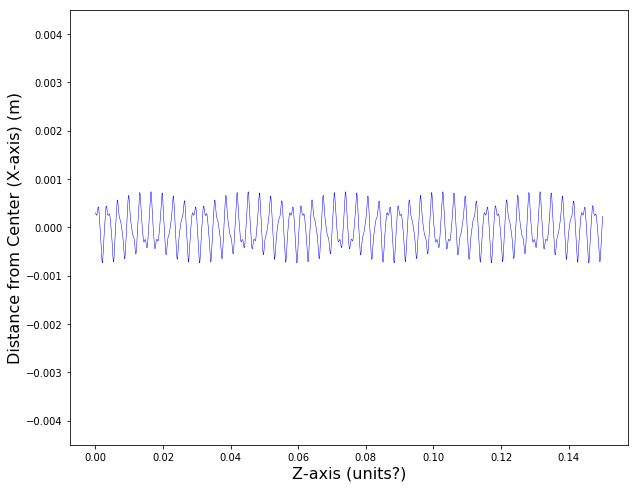

In [18]:
plt.subplots(figsize = (10,8))
plt.plot(z, solx[:,0], 'b', linewidth = 0.5)
plt.ylim(-radius,radius)
plt.xlabel("Z-axis (units?)", fontsize = 16)# need to figure this value out (maybe m but the start decimals places seem off)
plt.ylabel("Distance from Center (X-axis) (m)", fontsize = 16)# need to figure this value out (maybe m but the start decimals places seem off)

Text(0,0.5,'Distance from Center (Y-axis) (m)')

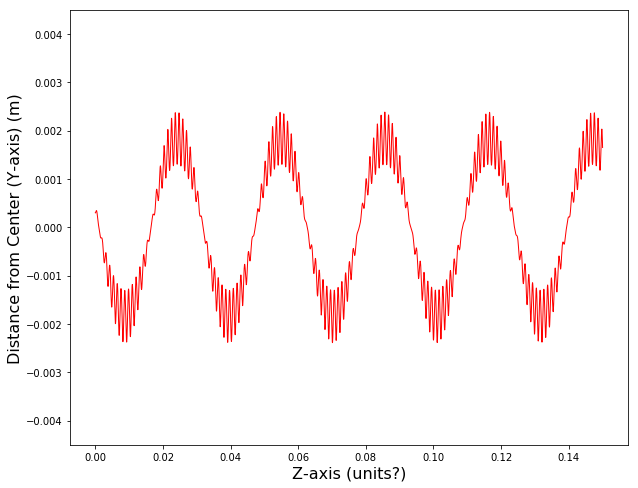

In [19]:
plt.subplots(figsize = (10,8))
plt.plot(z, soly[:,0], 'r', linewidth = 1.0)
plt.ylim(-radius,radius)
plt.xlabel("Z-axis (units?)", fontsize = 16)# need to figure this value out (maybe m but the start decimals places seem off)
plt.ylabel("Distance from Center (Y-axis) (m)", fontsize = 16)# 

In [20]:
print('a-value = %.5f'%ax)
print('q-value = %.5f'%qx)
print('a/q Ratio = %.5f'%(ax/qx))

a-value = 0.17605
q-value = 0.61234
a/q Ratio = 0.28750


#### BELOW IS OLD CODE THAT MAY OR MAY NOT WORK OR BE USEFUL!

In [21]:
e=1.602176462e-19     #Electroncharge
ukg=1.66054e-27     #1u=1*ukg kg

In [22]:
def get_x_path(
    ion_mz = 28.0,
    dc_offset = 20.0,
    rf_voltage = 123.5,
    rf_freq = 2*np.pi*2.02e+6,
    radius = 0.00275,
    acc_volts = 1,
    delta_t = 10e-9,
    z_length = 0.15,
    x_offset = 0.0003,
    vx0 = 0.0000,
    y_offset = 0.0003,
    vy0 = 0.0000,
    phase_entry = np.pi/4):
    
    vz=np.sqrt(1/ion_mz*2*acc_volts*e/ukg)  #Velocity in z
    tmax=z_length/vz      #Time for flight through
  
    phasepi=phase_entry
 
    ax=1/ion_mz*e/ukg*4*dc_offset/radius**2/rf_freq**2#ax-Value in stability diagram
    qx=1/ion_mz*e/ukg*2*rf_voltage/radius**2/rf_freq**2#qx-Value in stability diagram
    t = []
    numPnts = (rf_freq*tmax/2)/(rf_freq*delta_t/2.0)
    delta = rf_freq*delta_t/2
    for i,j in enumerate(range(int(numPnts))):
        t.append(i*delta)#,val[3]*tmax/2)
    t_array = np.array(t)
    solx=integrate.odeint(pendx,[x_offset, vx0], t = t_array, args = ([ax, qx, phasepi],)) #Solve x movement
    z = np.linspace(0, z_length, int(numPnts))
    return z, solx

In [23]:
def get_y_path(
    ion_mz = 28.0,
    dc_offset = 20.0,
    rf_voltage = 123.5,
    rf_freq = 2*np.pi*2.02e+6,
    radius = 0.00275,
    acc_volts = 1,
    delta_t = 10e-9,
    z_length = 0.15,
    x_offset = 0.0003,
    vx0 = 0.0000,
    y_offset = 0.0003,
    vy0 = 0.0000,
    phase_entry = np.pi/4):
    
    vz=np.sqrt(1/ion_mz*2*acc_volts*e/ukg)  #Velocity in z
    tmax=z_length/vz      #Time for flight through
  
    phasepi=phase_entry
 
    ax=1/ion_mz*e/ukg*4*dc_offset/radius**2/rf_freq**2#ax-Value in stability diagram
    qx=1/ion_mz*e/ukg*2*rf_voltage/radius**2/rf_freq**2#qx-Value in stability diagram
    t = []
    numPnts = (rf_freq*tmax/2)/(rf_freq*delta_t/2.0)
    delta = rf_freq*delta_t/2
    for i,j in enumerate(range(int(numPnts))):
        t.append(i*delta)#,val[3]*tmax/2)
    t_array = np.array(t)
    soly=integrate.odeint(pendy,[y_offset, vy0], t = t_array, args = ([ax, qx, phasepi],)) #Solve x movement
    z = np.linspace(0, z_length, int(numPnts))
    return z, soly

Text(0,0.5,'Distance from Center (X-axis) (m)')

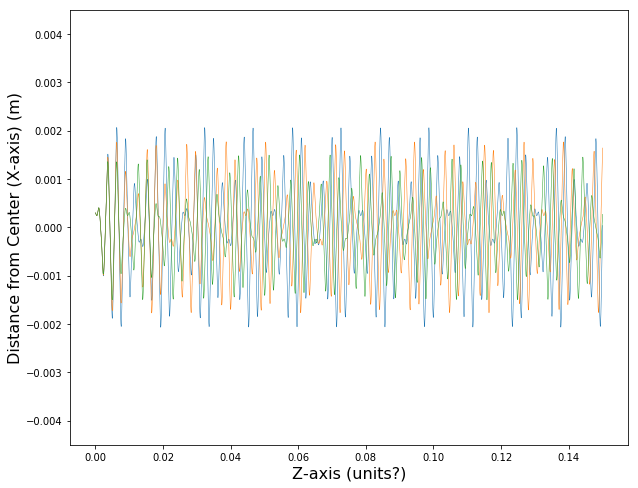

In [24]:
plt.subplots(figsize = (10,8))
for mz in [28.0,28.2,28.5]:
    x,y = get_x_path(ion_mz = mz)
    plt.plot(x,y[:,0], linewidth = 0.5)
    
plt.ylim(-radius,radius)
plt.xlabel("Z-axis (units?)", fontsize = 16)# need to figure this value out (maybe m but the start decimals places seem off)
plt.ylabel("Distance from Center (X-axis) (m)", fontsize = 16)#

Text(0,0.5,'Distance from Center (Y-axis) (m)')

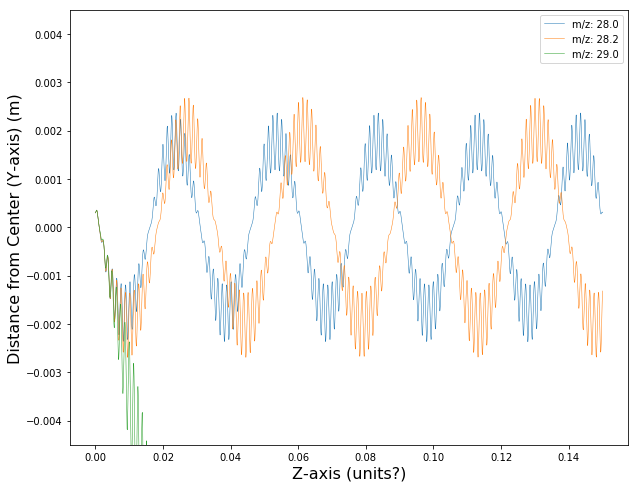

In [25]:
plt.subplots(figsize = (10,8))
for mz in [28.0,28.2,29.0]:
    x,y = get_y_path(ion_mz = mz)
    plt.plot(x,y[:,0], linewidth = 0.5, label = 'm/z: %s'%mz)
plt.legend()
plt.ylim(-radius,radius)
plt.xlabel("Z-axis (units?)", fontsize = 16)# need to figure this value out (maybe m but the start decimals places seem off)
plt.ylabel("Distance from Center (Y-axis) (m)", fontsize = 16)# 

(1000, 3)


(0, 20)

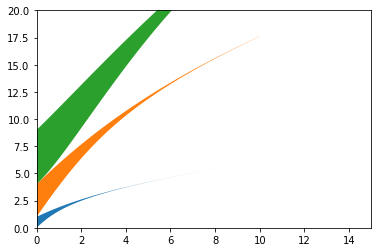

In [26]:
uplim =40#E_rec
Npts =1000
Nstates = 3
q = np.linspace(0, uplim/4.0, Npts)
EA = np.zeros([Npts,Nstates])
EB = np.zeros([Npts,Nstates])
U = 1*q 

print(np.shape(EA))    #plt.fill_between(U, EA[:,i], EB[:,i]) #plt.plot(U,Ea,U,Eb) 
for i in range(Nstates):
    a = sp.mathieu_a(i,q)
    b = sp.mathieu_b(i+1,q)
    EA[:,i] = a + 2*q
    EB[:,i] = b + 2*q 
    plt.fill_between(U, EA[:,i], EB[:,i]) #plt.plot(U,Ea,U,Eb)
plt.xlim(0,15)
plt.ylim(0,20)

In [27]:
def MathieuEquation(t,x):
# % Mathieu Equation is y''(z)+eta.y'(z)+(a-2qcos(2z))sin(y) = 0
# % Written into two first order differential equations
# % y'(z) = x 
# % x'(z) = -eta.y'(z)-(a-2qcos(2z))sin(y)
# %
    n = len(x)
    xdot=np.zeros(n)# does this need to be multidimensional?
    theta = x[0]
    Dtheta = x[1]
    q = x[2]
    a = x[3]
    eta = x[4]
    xdot[0] = Dtheta
    xdot[1] = -eta*Dtheta-(a-2*q*np.cos(2*t))*np.sin(theta)
    return xdot